In [1]:
import sys, os
import theano
import scipy
from collections import OrderedDict
from copy import deepcopy
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from theano import shared
import theano.tensor as tt
from theano.sandbox.rng_mrg import MRG_RandomStreams
import pymc3 as pm
from pymc3 import math as pmmath
from pymc3 import Dirichlet
from pymc3.distributions import Interpolated
from pymc3.distributions.transforms import t_stick_breaking
plt.style.use('seaborn-darkgrid')
from tqdm import tqdm
from collections import Counter
import scanpy as sc
import pandas as pd
sc.settings.autosave=False
sc.settings.autoshow=True
import anndata
import re


In [2]:
adatapaths=['/home/mt/Downloads/1k_hgmm','/scrapp2/mtschmitz/5k_pbmc_v3','/scrapp2/mtschmitz/E40_motor_Out','E50_motor_Out','E65_motor_Out','E80motor_Out','E100motor_Out']
genomenames=['','',"refdata-celranger-mmul8-toplevel","refdata-celranger-mmul8-toplevel","refdata-celranger-mmul8-toplevel",
            "refdata-celranger-mmul8-toplevel","refdata-celranger-mmul8-toplevel"]
samplenames=['1kHGMM','5kPCMB','E40','E50','E65','E80','E100']
adatapath=adatapaths[0]
#genomename="refdata-celranger-mmul8-toplevel"
genomename=''
samplename=samplenames[0]

In [ ]:
print(samplename, flush=True)
maxgenes=4000
n_iterations=100
#Number of topics, not including ambient topic
K=10
subtractive=False
sc.settings.figdir=os.path.expanduser('~/figs/'+str(subtractive)+'/'+samplename)
if not os.path.exists(sc.settings.figdir):
        os.makedirs(sc.settings.figdir)

adata = sc.read_10x_mtx(os.path.join(adatapath,'outs/raw_feature_bc_matrix'),cache=True)
bcs=list(pd.read_csv(os.path.join(adatapath,'outs/filtered_feature_bc_matrix','barcodes.tsv.gz')).iloc[:,0])
#adata = sc.read_10x_h5('/home/mt/code/data/AlignedOrangutanOrganoid/Exonic/orangutanorganoid_Out/outs/filtered_gene_bc_matrices_h5.h5','refdata-celranger-Pabe2-toplevel')
sc.pp.filter_genes(adata, min_cells=10,inplace=True)
sc.pp.filter_cells(adata,min_counts=1,inplace=True)
plt.close()
sns.distplot(np.log10(adata.X.sum(1).A1),kde=False)
plt.savefig(os.path.join(sc.settings.figdir,'DropCountsHist.png'))
plt.close()
sc.pp.filter_cells(adata,min_counts=15,inplace=True)
adata=adata[adata.obs.n_counts.argsort(),:]

adata.var_names_make_unique()
freshadata=adata.copy()
print('original shape',freshadata.shape)
cell_inds=np.where([x in bcs for x in adata.obs.index])[0]
junk_inds=np.where([x not in bcs for x in adata.obs.index])[0]

ambient_counts=np.log10(adata[[x not in bcs for x in adata.obs.index] ,:].X.sum(1).A1)
adata._inplace_subset_var((-adata[junk_inds,:].X).sum(0).A1.argsort()[0:min(maxgenes,adata.shape[1])])
phiAmbient = adata[junk_inds,:].X.sum(axis=0)/adata[junk_inds,:].X.sum(axis=1).sum()
phiAmbientDict=dict(zip(list(adata.var.index), phiAmbient.A1))
adata._inplace_subset_obs(cell_inds)
freshadata._inplace_subset_obs(cell_inds)

feature_names=list(adata.var.index)
tf=adata.X
n_tokens = np.sum(tf[tf.nonzero()])
print('Number of tokens in training set = {}'.format(n_tokens))
print('Sparsity = {}'.format(
    len(tf.nonzero()[0]) / float(tf.shape[0] * tf.shape[1])))



1kHGMM


Trying to set attribute `.var` of view, making a copy.


1073 4000
Ambient Mean 1.6355431
Ambient STD 0.14536236
l __str__ = -1630444078.4103117
l __str__ = -205149291.39398345
l __str__ = -68283.59421120584
l __str__ = -231178915.39398345
l __str__ = -1630444078.4103117
l __str__ = -205149291.39398345
l __str__ = -68283.59421120584
l __str__ = -231178915.39398345
l __str__ = -1630444078.4103117
l __str__ = -205149291.39398345
l __str__ = -68283.59421120584
l __str__ = -231178915.39398345


Average Loss = 2.1052e+08: 100%|██████████| 100/100 [02:47<00:00,  1.51s/it]
Finished [100%]: Average Loss = 2.0975e+08


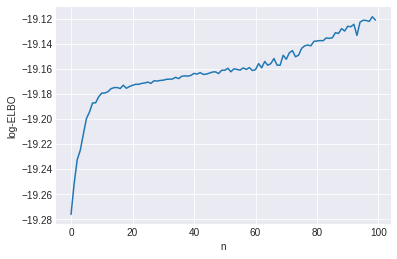

In [4]:
model1 = pm.Model()
(D,V)=tf.shape
print(D,V)
alpha = np.ones((1, K))*.1
beta = np.ones((1, V))*.1
sparse_array=shared(np.array([tf.nonzero()[0],tf.nonzero()[1],tf.data]).T.astype('int32'))
tt.cast(sparse_array,'int32')
rowsums=shared(np.sum(tf,axis=1).T)
sumall=shared(np.sum(tf))
print("Ambient Mean",np.mean(ambient_counts), flush=True)
print("Ambient STD",np.std(ambient_counts), flush=True)
def lognormpdf(mean, sd):
    import math
    def internalnorm(x):
        var = float(sd)**2
        denom = tt.log(2*math.pi*var)*.5
        num = -(x-float(mean))**2/(2*var)
        return(num-denom)
    return internalnorm
ambient=lognormpdf(np.mean(ambient_counts),np.std(ambient_counts))

def log_lda(theta, phi,value,rowsums,sumall,phiAmbient=None):
    if phiAmbient is not None:
        phi=tt.concatenate([phi,phiAmbient],axis=0)
    else:
        phi=phi
    ll = value[:,2] * pm.math.logsumexp(tt.log(theta[value[:,0].astype('int32')]+1e-9)+ tt.log(phi.T[value[:,1].astype('int32')]+1e-9),axis=1).ravel()                                                                  
    ambientll=ambient(tt.log10((rowsums+1e-9)*(theta[:,theta.shape[1]-1]+1e-9)))
    tt.printing.Print('l')(tt.sum(ambientll)*(sumall/rowsums.shape[1]))
    tt.printing.Print('l')(tt.sum(ll))
    tt.printing.Print('l')(tt.sum(ambientll)-rowsums.shape[1])
    tt.printing.Print('l')(tt.sum(ll)-sumall)
    #return tt.sum(ll) + tt.sum(ambientll)*(sumall/rowsums.shape[1])
    return (tt.sum(ll)-sumall) + (tt.sum(ambientll)-rowsums.shape[1])

with model1: 
    theta = pm.Dirichlet("theta", a=alpha, shape=(D, K), transform=t_stick_breaking(1e-9)).astype('float32')
    phi = pm.Dirichlet("phi", a=beta, shape=(K-1, V), transform=t_stick_breaking(1e-9)).astype('float32')
    #ambient=from_epdf('ambient',ambient_counts)
    #doc = pm.DensityDist('doc', log_lda, observed=dict(theta=theta, phi=phi,ambient=ambient, value=sparse_array,phiAmbient=np.matrix([phiAmbientDict[x] for x in feature_names]),rowsums=rowsums,sumall=sumall))
    doc = pm.DensityDist('doc', log_lda, observed=dict(theta=theta,
        phi=phi,
        value=sparse_array,phiAmbient=np.matrix([phiAmbientDict[x] for x in feature_names]),rowsums=rowsums,sumall=sumall))    
    
eta = .3
s = shared(eta)
def reduce_rate(a, h, i):
    s.set_value(eta/((i+1)/100)**.4)   
    
with model1:    
    #inference = pm.ADVI()
    #inference = pm.FullRankADVI()
    inference=pm.variational.NFVI()
    approx = pm.fit(n=200,method=inference,obj_optimizer=pm.adam(learning_rate=s))#,callbacks=[reduce_rate])


tr1 = approx.sample(draws=1000)
advi_elbo = pd.DataFrame(
    {'log-ELBO': -np.log(approx.hist),
     'n': np.arange(approx.hist.shape[0])})
plt.clf()
sns.lineplot(y='log-ELBO', x='n', data=advi_elbo)
plt.savefig(os.path.join(sc.settings.figdir,'ELBO.png'))
theta=tr1['theta'].mean(0)
theta=anndata.AnnData(theta,var=pd.DataFrame(index=['lda_'+str(i) for i in range(K) ]),obs=pd.DataFrame(index=list(adata.obs.index)))
for i in range(theta.shape[1]):
    freshadata.obs['lda_'+str(i)]=theta[:,i].X

# In[15]:
phi=tr1['phi'].mean(0)
phi=anndata.AnnData(phi,var=pd.DataFrame(index=feature_names),obs=pd.DataFrame(index=['lda_'+str(i) for i in range(K-1) ]))

for i in range(phi.shape[0]):
    freshadata.var['lda_'+str(i)]=0
    freshadata.var.loc[list(phiAmbientDict.keys()),'lda_'+str(i)]=phi[i,:][:,list(phiAmbientDict.keys())].X
freshadata.var['lda_'+str(K-1)]=0
#Resort indices so the ones we're subtracting from are listed first
freshadata.var.loc[list(phiAmbientDict.keys()),'lda_'+str(K-1)]=list(phiAmbientDict.values())
fullinds=list(freshadata.var.index)
[fullinds.insert(0, fullinds.pop(fullinds.index(i))) for i in feature_names[::-1]]
freshadata=freshadata[:,fullinds]
#Reassign phiAmbient now that matrix is reordered
phiAmbientDict=dict(zip(list(freshadata.var.index),list(freshadata.var['lda_'+str(K-1)])))
#phiAmbient=np.array(freshadata.var['lda_'+str(K-1)])    

In [5]:
adata.var['Mouse'] = ['mm10' in x for x in adata.var.index]
adata.obs['PercentM'] =adata[:,list(adata.var['Mouse'])].X.sum(1)/adata.X.sum(1)
adata.obs['Mcounts'] =adata[:,list(adata.var['Mouse'])].X.sum(1)
adata.obs['Hcounts'] =adata[:,list(np.invert(adata.var['Mouse']))].X.sum(1)
freshadata.var['Mouse'] = ['mm10' in x for x in freshadata.var.index]
freshadata.obs['PercentM'] =freshadata[:,list(freshadata.var['Mouse'])].X.sum(1)/freshadata.X.sum(1)
freshadata.obs['Mcounts'] =freshadata[:,list(freshadata.var['Mouse'])].X.sum(1)
freshadata.obs['Hcounts'] =freshadata[:,list(np.invert(freshadata.var['Mouse']))].X.sum(1)


Trying to set attribute `.var` of view, making a copy.


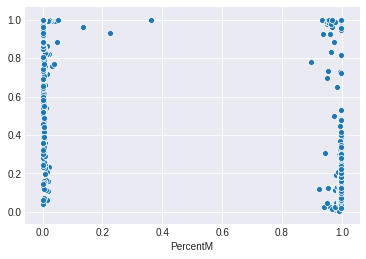

[[1.         0.42467315]
 [0.42467315 1.        ]]
[[1.         0.97427179]
 [0.97427179 1.        ]]


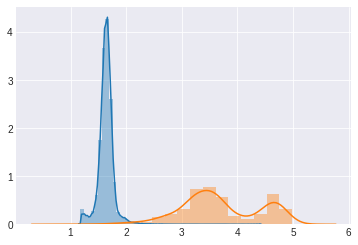

In [6]:
sns.scatterplot(adata.obs['PercentM'],theta[:,9].X)
plt.show()
humanmousegenes=adata[adata.obs['PercentM']<.2,][:,adata.var['Mouse']]
print(np.corrcoef( humanmousegenes.X.sum(0) ,[phiAmbientDict[i] for i in humanmousegenes.var.index]))
mousehumangenes=adata[adata.obs['PercentM']>.8,][:,np.invert(adata.var['Mouse'])]
print(np.corrcoef( mousehumangenes.X.sum(0) ,[phiAmbientDict[i] for i in mousehumangenes.var.index]))
sns.distplot(ambient_counts)
sns.distplot(np.log10(adata.X.sum(1).A1*theta[:,9].X))


[[1.         0.45140358]
 [0.45140358 1.        ]]
[[1.         0.45140358]
 [0.45140358 1.        ]]
[[1.         0.97356855]
 [0.97356855 1.        ]]


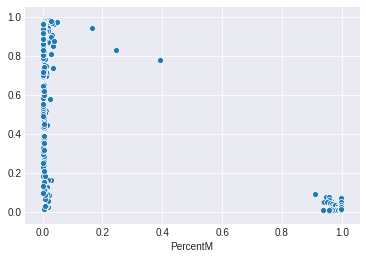

In [7]:
sns.scatterplot(freshadata.obs['PercentM'],theta[:,9].X)
humanmousegenes=freshadata[freshadata.obs['PercentM']<.2,][:,freshadata.var['Mouse']]
print(np.corrcoef( humanmousegenes.X.sum(0) ,[phiAmbientDict[i] for i in humanmousegenes.var.index]))
print(np.corrcoef( humanmousegenes.X.sum(0).A1 ,humanmousegenes.var['lda_9']))
mousehumangenes=freshadata[freshadata.obs['PercentM']>.8,][:,np.invert(freshadata.var['Mouse'])]
print(np.corrcoef( mousehumangenes.X.sum(0) ,[phiAmbientDict[i] for i in mousehumangenes.var.index]))


In [8]:
mats=[]

In [9]:
#subtractive corrected countz numerator
tmpmat3=scipy.sparse.csr_matrix(freshadata.shape)
theta=np.matrix(freshadata.obs.loc[:,['lda' in x for x in freshadata.obs.columns]])
phi=np.matrix(freshadata.var.loc[:,['lda' in x for x in freshadata.var.columns]])
#txp=theta[:,0:(K-1)]*phi[:,0:(K-1)].T
for ci,c in tqdm(enumerate(freshadata.obs.index)):
    farow=freshadata[c,:].X
    rowinds=farow.nonzero()[0]
    countz=farow[rowinds]
    rowtxp=(theta[ci,0:(K-1)]*phi[:,0:(K-1)].T).A1 #memory saving #txp[ci,:].A1
    rowtxpamb=(theta[ci,(K-1)]*phi[:,(K-1)].T).A1
    indmultiset=[[rowinds[i]]*int(countz[i]) for i in range(len(countz))]
    vals = np.array([item for sublist in indmultiset for item in sublist])
    phimultiset=[[rowtxpamb[rowind]/countz[i]]*int(countz[i]) for i,rowind in enumerate(rowinds)]
    pvals = np.array([item for sublist in phimultiset for item in sublist])
    phimultiset=[[rowtxp[rowind]+rowtxpamb[rowind]+1e-10]*int(countz[i]) for i,rowind in enumerate(rowinds)]
    pvalsdenom = np.array([item for sublist in phimultiset for item in sublist])
    pvals=pvals/(pvalsdenom)
    vals=vals[pvals>0]
    pvals=pvals[pvals>0]
    if len(vals)>0:
        #Select counts based on phiAmbient
        cellcount=np.sum(freshadata[c,:][:,feature_names].X)
        countremove=Counter(np.random.choice(vals,replace=False,size=min(len(vals),int(theta[ci,theta.shape[1]-1]*cellcount)),p=np.array(pvals)/sum(pvals))) 
        tmpmat3[ci,list(countremove.keys())]=list(countremove.values())




245it [00:11, 13.10it/s]

KeyboardInterrupt: 

[[1.         0.87549283]
 [0.87549283 1.        ]]
[[1.         0.84465895]
 [0.84465895 1.        ]]


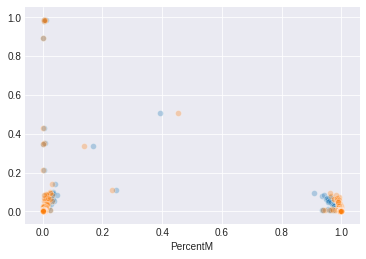

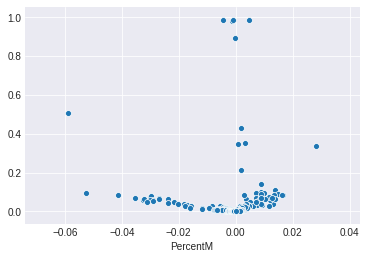

In [10]:
print(np.corrcoef(tmpmat3.sum(0),[phiAmbientDict[i] for i in freshadata.var.index]), flush=True)
newmat=freshadata.X-tmpmat3
mats.append(newmat)
newmat[:,list(freshadata.var['Mouse'])].sum(1)/newmat.sum(1)
print(np.corrcoef(newmat.sum(0),[phiAmbientDict[i] for i in freshadata.var.index]), flush=True)
sns.scatterplot(freshadata.obs['PercentM'],theta[:,9].A1,alpha=.3)
sns.scatterplot(newmat[:,np.where(list(freshadata.var['Mouse']))[0]].sum(1).A1/newmat.sum(1).A1,theta[:,9].A1,alpha=.3)
plt.show()
sns.scatterplot(freshadata.obs['PercentM']-newmat[:,np.where(list(freshadata.var['Mouse']))[0]].sum(1).A1/newmat.sum(1).A1,theta[:,9].A1)
plt.show()

In [11]:
#additive
tmpmat=scipy.sparse.csr_matrix(freshadata.shape)
theta=np.matrix(freshadata.obs.loc[:,['lda' in x for x in freshadata.obs.columns]])
phi=np.matrix(freshadata.var.loc[:,['lda' in x for x in freshadata.var.columns]])
#txp=theta[:,0:(K-1)]*phi[:,0:(K-1)].T
for ci,c in tqdm(enumerate(freshadata.obs.index)):
    farow=freshadata[c,:].X
    rowinds=farow.nonzero()[0]
    countz=farow[rowinds]
    rownames=freshadata.var.index[rowinds]
    rowtxp=(theta[ci,0:(K-1)]*phi[:,0:(K-1)].T).A1 #memory saving #txp[ci,:].A1
    indmultiset=[[rowinds[i]]*int(countz[i]) for i in range(len(countz))]
    vals = [item for sublist in indmultiset for item in sublist]
    phimultiset=[[rowtxp[rowind]/countz[i]]*int(countz[i]) for i,rowind in enumerate(rowinds)]
    pvals = [item for sublist in phimultiset for item in sublist]
    if len(vals)>0:
        #Select counts based on phiAmbient
        cellcount=np.sum(freshadata[c,:][:,feature_names].X)
        countremove=Counter(np.random.choice(vals,replace=False,size=min(len(vals),int((1-theta[ci,(K-1)])*cellcount)),p=np.array(pvals)/sum(pvals))) 
        tmpmat[ci,list(countremove.keys())]=list(countremove.values())
ambmat=freshadata.X-tmpmat
mats.append(tmpmat)

111it [00:02, 29.27it/s]


KeyboardInterrupt: 

In [ ]:
print(np.corrcoef(tmpmat.sum(0),[phiAmbientDict[i] for i in freshadata.var.index]), flush=True)
print(np.corrcoef(ambmat.sum(0),[phiAmbientDict[i] for i in freshadata.var.index]), flush=True)
print(np.corrcoef(freshadata.X.sum(0),[phiAmbientDict[i] for i in freshadata.var.index]), flush=True)
print(np.corrcoef(freshadata.var['lda_9'],[phiAmbientDict[i] for i in freshadata.var.index]), flush=True)


In [ ]:
newmat=tmpmat
newmat[:,list(freshadata.var['Mouse'])].sum(1)/newmat.sum(1)
sns.scatterplot(freshadata.obs['PercentM']-newmat[:,np.where(list(freshadata.var['Mouse']))[0]].sum(1).A1/newmat.sum(1).A1,theta[:,9].A1)
plt.show()
sns.scatterplot(freshadata.obs['PercentM'],theta[:,9].A1,alpha=.3)
sns.scatterplot(newmat[:,np.where(list(freshadata.var['Mouse']))[0]].sum(1).A1/newmat.sum(1).A1,theta[:,9].A1,alpha=.3)


In [ ]:
#additive without countz
tmpmat=scipy.sparse.csr_matrix(freshadata.shape)
theta=np.matrix(freshadata.obs.loc[:,['lda' in x for x in freshadata.obs.columns]])
phi=np.matrix(freshadata.var.loc[:,['lda' in x for x in freshadata.var.columns]])
#txp=theta[:,0:(K-1)]*phi[:,0:(K-1)].T
for ci,c in tqdm(enumerate(freshadata.obs.index)):
    farow=freshadata[c,:].X
    rowinds=farow.nonzero()[0]
    countz=farow[rowinds]
    rownames=freshadata.var.index[rowinds]
    rowtxp=(theta[ci,0:(K-1)]*phi[:,0:(K-1)].T).A1 #memory saving #txp[ci,:].A1
    indmultiset=[[rowinds[i]]*int(countz[i]) for i in range(len(countz))]
    vals = [item for sublist in indmultiset for item in sublist]
    phimultiset=[[rowtxp[rowind]]*int(countz[i]) for i,rowind in enumerate(rowinds)]
    pvals = [item for sublist in phimultiset for item in sublist]
    if len(vals)>0:
        #Select counts based on phiAmbient
        cellcount=np.sum(freshadata[c,:][:,feature_names].X)
        countremove=Counter(np.random.choice(vals,replace=False,size=min(len(vals),int((1-theta[ci,(K-1)])*cellcount)),p=np.array(pvals)/sum(pvals))) 
        tmpmat[ci,list(countremove.keys())]=list(countremove.values())
ambmat=freshadata.X-tmpmat
mats.append(tmpmat)

In [ ]:
print(np.corrcoef(tmpmat.sum(0),[phiAmbientDict[i] for i in freshadata.var.index]), flush=True)
print(np.corrcoef(ambmat.sum(0),[phiAmbientDict[i] for i in freshadata.var.index]), flush=True)


In [ ]:
newmat=tmpmat
newmat[:,list(freshadata.var['Mouse'])].sum(1)/newmat.sum(1)
sns.scatterplot(freshadata.obs['PercentM']-newmat[:,np.where(list(freshadata.var['Mouse']))[0]].sum(1).A1/newmat.sum(1).A1,theta[:,9].A1)
plt.show()
sns.scatterplot(freshadata.obs['PercentM'],theta[:,9].A1,alpha=.3)
sns.scatterplot(newmat[:,np.where(list(freshadata.var['Mouse']))[0]].sum(1).A1/newmat.sum(1).A1,theta[:,9].A1,alpha=.3)


In [ ]:
#Subtractive with countz correction
theta=tr1['theta'].mean(0)
theta=anndata.AnnData(theta,var=pd.DataFrame(index=['lda_'+str(i) for i in range(K) ]),obs=pd.DataFrame(index=list(adata.obs.index)))
# In[15]:
phi=tr1['phi'].mean(0)
phi=anndata.AnnData(phi,var=pd.DataFrame(index=feature_names),obs=pd.DataFrame(index=['lda_'+str(i) for i in range(K-1) ]))
#Reassign phiAmbient now that matrix is reordered
phiAmbientDict=dict(zip(list(freshadata.var.index),list(freshadata.var['lda_'+str(K-1)])))
#phiAmbient=np.array(freshadata.var['lda_'+str(K-1)])    

tmpmat2=scipy.sparse.csr_matrix(freshadata.shape)
for ci,c in tqdm(enumerate(freshadata.obs.index)):
    farow=freshadata[c,:].X
    rowinds=farow.nonzero()[0]
    countz=farow[rowinds]
    rownames=freshadata.var.index[rowinds]
    indmultiset=[[rowinds[i]]*int(countz[i]) for i in range(len(countz))]
    vals = [item for sublist in indmultiset for item in sublist]
    #phimultiset=[[phiAmbientDict[rowname]]*int(countz[i]) for i,rowname in enumerate(rownames)]
    phimultiset=[[phiAmbientDict[rowname]/countz[i]]*int(countz[i]) for i,rowname in enumerate(rownames)]
    pvals = [item for sublist in phimultiset for item in sublist]
    if len(vals)>0:
        #Select counts based on phiAmbient
        cellcount=np.sum(freshadata[c,:][:,feature_names].X)
        countremove=Counter(np.random.choice(vals,replace=False,size=min(len(vals),int(theta[c,theta.shape[1]-1].X*cellcount)),p=np.array(pvals)/sum(pvals))) 
        tmpmat2[ci,list(countremove.keys())]=list(countremove.values())


In [ ]:
print(np.corrcoef(tmpmat2.sum(0),[phiAmbientDict[i] for i in freshadata.var.index]), flush=True)
plt.close()
newmat=freshadata.X-tmpmat2
mats.append(newmat)
newmat[:,list(freshadata.var['Mouse'])].sum(1)/newmat.sum(1)
sns.scatterplot(freshadata.obs['PercentM']-newmat[:,np.where(list(freshadata.var['Mouse']))[0]].sum(1).A1/newmat.sum(1).A1,theta[:,9].X)
plt.show()
sns.scatterplot(freshadata.obs['PercentM'],theta[:,9].X,alpha=.3)
sns.scatterplot(newmat[:,np.where(list(freshadata.var['Mouse']))[0]].sum(1).A1/newmat.sum(1).A1,theta[:,9].X,alpha=.3)


In [ ]:
#Subtractive Without countz balance
theta=tr1['theta'].mean(0)
theta=anndata.AnnData(theta,var=pd.DataFrame(index=['lda_'+str(i) for i in range(K) ]),obs=pd.DataFrame(index=list(adata.obs.index)))
# In[15]:
phi=tr1['phi'].mean(0)
phi=anndata.AnnData(phi,var=pd.DataFrame(index=feature_names),obs=pd.DataFrame(index=['lda_'+str(i) for i in range(K-1) ]))
#Reassign phiAmbient now that matrix is reordered
phiAmbientDict=dict(zip(list(freshadata.var.index),list(freshadata.var['lda_'+str(K-1)])))
#phiAmbient=np.array(freshadata.var['lda_'+str(K-1)])    

tmpmat2=scipy.sparse.csr_matrix(freshadata.shape)
for ci,c in tqdm(enumerate(freshadata.obs.index)):
    farow=freshadata[c,:].X
    rowinds=farow.nonzero()[0]
    countz=farow[rowinds]
    rownames=freshadata.var.index[rowinds]
    indmultiset=[[rowinds[i]]*int(countz[i]) for i in range(len(countz))]
    vals = [item for sublist in indmultiset for item in sublist]
    #phimultiset=[[phiAmbientDict[rowname]]*int(countz[i]) for i,rowname in enumerate(rownames)]
    phimultiset=[[phiAmbientDict[rowname]]*int(countz[i]) for i,rowname in enumerate(rownames)]
    pvals = [item for sublist in phimultiset for item in sublist]
    if len(vals)>0:
        #Select counts based on phiAmbient
        cellcount=np.sum(freshadata[c,:][:,feature_names].X)
        countremove=Counter(np.random.choice(vals,replace=False,size=min(len(vals),int(theta[c,theta.shape[1]-1].X*cellcount)),p=np.array(pvals)/sum(pvals))) 
        tmpmat2[ci,list(countremove.keys())]=list(countremove.values())


In [ ]:
print(np.corrcoef(tmpmat2.sum(0),[phiAmbientDict[i] for i in freshadata.var.index]), flush=True)
plt.close()
newmat=freshadata.X-tmpmat2
mats.append(newmat)
newmat[:,list(freshadata.var['Mouse'])].sum(1)/newmat.sum(1)
sns.scatterplot(freshadata.obs['PercentM']-newmat[:,np.where(list(freshadata.var['Mouse']))[0]].sum(1).A1/newmat.sum(1).A1,theta[:,9].X)
plt.show()
sns.scatterplot(freshadata.obs['PercentM'],theta[:,9].X,alpha=.3)
sns.scatterplot(newmat[:,np.where(list(freshadata.var['Mouse']))[0]].sum(1).A1/newmat.sum(1).A1,theta[:,9].X,alpha=.3)


In [ ]:
#subtractive nocountz
tmpmat4=scipy.sparse.csr_matrix(freshadata.shape)
theta=np.matrix(freshadata.obs.loc[:,['lda' in x for x in freshadata.obs.columns]])
phi=np.matrix(freshadata.var.loc[:,['lda' in x for x in freshadata.var.columns]])
#txp=theta[:,0:(K-1)]*phi[:,0:(K-1)].T
for ci,c in tqdm(enumerate(freshadata.obs.index)):
    rowphi=phi[ci,:].A1
    farow=freshadata[c,:].X
    rowinds=farow.nonzero()[0]
    countz=farow[rowinds]
    rownames=freshadata.var.index[rowinds]
    rowtxp=(theta[ci,0:(K-1)]*phi[:,0:(K-1)].T).A1 #memory saving #txp[ci,:].A1
    indmultiset=[[rowinds[i]]*int(countz[i]) for i in range(len(countz))]
    vals = [item for sublist in indmultiset for item in sublist]
    phimultiset=[[rowphi[K-1]]*int(countz[i]) for i,rowind in enumerate(rowinds)]
    pvals = np.array([item for sublist in phimultiset for item in sublist])
    phimultiset=[[rowtxp[rowind]]*int(countz[i]) for i,rowind in enumerate(rowinds)]
    pvalsdenom = np.array([item for sublist in phimultiset for item in sublist])
    pvals=pvals/(pvals+pvalsdenom)
    if len(vals)>0:
        #Select counts based on phiAmbient
        cellcount=np.sum(freshadata[c,:][:,feature_names].X)
        countremove=Counter(np.random.choice(vals,replace=False,size=min(len(vals),int(theta[ci,theta.shape[1]-1]*cellcount)),p=np.array(pvals)/sum(pvals))) 
        tmpmat4[ci,list(countremove.keys())]=list(countremove.values())




In [ ]:
print(np.corrcoef(tmpmat4.sum(0),[phiAmbientDict[i] for i in freshadata.var.index]), flush=True)
newmat=freshadata.X-tmpmat4
mats.append(newmat)
newmat[:,list(freshadata.var['Mouse'])].sum(1)/newmat.sum(1)
print(np.corrcoef(newmat.sum(0),[phiAmbientDict[i] for i in freshadata.var.index]), flush=True)
sns.scatterplot(freshadata.obs['PercentM'],theta[:,9].A1,alpha=.3)
sns.scatterplot(newmat[:,np.where(list(freshadata.var['Mouse']))[0]].sum(1).A1/newmat.sum(1).A1,theta[:,9].A1,alpha=.3)
plt.show()
sns.scatterplot(freshadata.obs['PercentM']-newmat[:,np.where(list(freshadata.var['Mouse']))[0]].sum(1).A1/newmat.sum(1).A1,theta[:,9].A1)

In [ ]:
absols=[]
for m in mats:
    pm=m[:,np.where(list(freshadata.var['Mouse']))[0]].sum(1).A1/m.sum(1).A1
    m=m[(pm>.85) | (pm<.13),:]
    absol=np.absolute(.5-(m[:,np.where(list(freshadata.var['Mouse']))[0]].sum(1).A1/m.sum(1).A1))
    sns.scatterplot(theta[(pm>.85) | (pm<.13),9].A1,absol)
    plt.show()
    #sns.distplot(absol,kde=False)
    #plt.show()
    absols.append(np.mean(absol))
    print(np.median(absol))

# multiseq test

In [2]:
maxgenes=1000
ncells=500
headpath=os.path.expanduser("/home/mt/Downloads/")
adata=sc.read_h5ad(os.path.join(headpath,'MultiseqRaw.h5ad'))
adata._inplace_subset_obs(adata.obs['batch']=='0')
cells=np.random.choice(adata.obs.index,ncells,replace=False)
sc.pp.filter_cells(adata,min_counts=15,inplace=True)
adata._inplace_subset_obs(cells)
adata._inplace_subset_var((-adata.X).sum(0).A1.argsort()[0:min(maxgenes,adata.shape[1])])

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=min(maxgenes,4000))
sc.pp.scale(adata, max_value=10)
#sc.pp.regress_out(adata,'n_counts')

sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)
clusters=adata.obs['leiden']

/home/mt/code/utils/miniconda3/envs/pymc/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../utils/miniconda3/envs/pymc/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/home/mt/code/utils/miniconda3/envs/pymc/lib/python3.7/site-packages/numba/compiler.py:725: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../utils/miniconda3/envs/pymc/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/home/mt/code/utils/miniconda3/envs/pymc/lib/p

In [48]:
headpath=os.path.expanduser("/home/mt/Downloads/")
adata=sc.read_h5ad(os.path.join(headpath,'MultiseqRaw.h5ad'))
adata._inplace_subset_obs(cells)
adata._inplace_subset_var((-adata.X).sum(0).A1.argsort()[0:min(maxgenes,adata.shape[1])])
adata.obs['leiden']=clusters
freshadata=adata.copy()

In [49]:
ambmu,ambsd=2.0,.4
K=10
n_iterations=120

In [50]:
clusterphis=[]
for c in set(clusters):
    clusterphis.append(adata[adata.obs['leiden']==c,:].X.sum(0).A1)
clusterphis=np.matrix(clusterphis)
clusterphis=clusterphis/(clusterphis.sum(1))

def Stick_Breaking(num_weights, alpha):
    betas = np.random.beta(1, alpha, size=num_weights)
    betas[1:] *= np.cumprod(1 - betas[:-1])
    return betas
ambprops=Stick_Breaking(len(set(clusters)),1)
ambcounts=[int(x) for x in 10**np.random.normal(ambmu,ambsd,adata.shape[0])]
print(ambprops)
sum(ambprops)


[4.83806448e-01 4.55582668e-01 5.65667396e-02 2.85052405e-03
 1.00356044e-03 9.06094865e-05 9.33216895e-05 1.57347838e-06]


0.9999954449223862

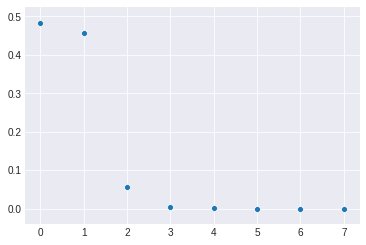

In [51]:
sns.scatterplot(list(range(len(ambprops))),ambprops)

In [52]:
phiAmbient=(ambprops*clusterphis).A1
phiAmbient=phiAmbient/phiAmbient.sum()
phiAmbientDict=dict(zip(list(adata.var.index), phiAmbient))
tmpmat=scipy.sparse.csr_matrix(adata.shape)
for ci,c in tqdm(enumerate(adata.obs.index)):
    countremove=Counter(np.random.choice(list(range(len(phiAmbient))),replace=True,size=ambcounts[ci],p=phiAmbient))
    tmpmat[ci,list(countremove.keys())]=list(countremove.values())

500it [00:00, 854.35it/s] 


In [53]:
adata.X.sum()

1003427.0

In [54]:
adata.X=adata.X+tmpmat

In [55]:
(adata.X-tmpmat).sum()

1003427.0

In [56]:
np.corrcoef(tmpmat.sum(0).A1,phiAmbient)

array([[1.        , 0.99959297],
       [0.99959297, 1.        ]])

In [57]:
phiAmbient

array([4.51675966e-02, 2.84251831e-02, 8.07545475e-02, 1.76612007e-04,
       2.27211472e-02, 1.98825417e-02, 1.46014769e-02, 6.56433649e-03,
       1.53570076e-02, 1.15492624e-02, 7.01646453e-03, 9.95009443e-03,
       8.96705069e-03, 5.16107142e-03, 8.70412201e-03, 7.57909067e-03,
       2.78297269e-03, 6.77633565e-03, 6.07246244e-03, 5.26588482e-03,
       6.41715614e-03, 4.80881218e-03, 6.26022325e-03, 1.92171889e-03,
       6.22759853e-03, 5.68971850e-03, 5.46978854e-03, 1.40277004e-04,
       6.41029950e-03, 4.77590644e-03, 5.38867698e-03, 5.25384473e-03,
       5.24262728e-03, 5.55701814e-03, 4.63572276e-05, 4.92554526e-03,
       4.48770758e-03, 2.97014755e-03, 4.43838526e-03, 4.03266979e-03,
       3.24399936e-03, 5.31465395e-03, 4.77809052e-03, 4.25591840e-03,
       3.80016232e-03, 4.63959756e-03, 4.23299796e-03, 3.57113286e-03,
       3.44532395e-03, 4.04544324e-03, 3.32167771e-03, 3.50353097e-03,
       8.27578916e-04, 1.75389266e-03, 2.67698090e-03, 3.94868157e-03,
      

In [61]:
feature_names=list(adata.var.index)
tf=adata.X
n_tokens = np.sum(tf[tf.nonzero()])
print('Number of tokens in training set = {}'.format(n_tokens))
print('Sparsity = {}'.format(
    len(tf.nonzero()[0]) / float(tf.shape[0] * tf.shape[1])))

model1 = pm.Model()
(D,V)=tf.shape
print(D,V)
alpha = np.ones((1, K))*.1
phi = np.ones((1, V))*1
sparse_array=shared(np.array([tf.nonzero()[0],tf.nonzero()[1],tf.data]).T.astype('int32'))
tt.cast(sparse_array,'int32')
rowsums=shared(np.sum(tf,axis=1).T)
sumall=shared(np.sum(tf))
def lognormpdf(mean, sd):
    import math
    def internalnorm(x):
        var = float(sd)**2
        denom = tt.log(2*math.pi*var)*.5
        num = -(x-float(mean))**2/(2*var)
        return(num-denom)
    return internalnorm
ambient=lognormpdf(ambmu,ambsd)

def log_lda(theta, phi,value,rowsums,sumall,phiAmbient=None):
    if phiAmbient is not None:
        phi=tt.concatenate([phi,phiAmbient],axis=0)
    else:
        phi=phi
    ll = value[:,2] * pm.math.logsumexp(tt.log(theta[value[:,0].astype('int32')]+1e-9)+ tt.log(phi.T[value[:,1].astype('int32')]+1e-9),axis=1).ravel()                                                                  
    ambientll=ambient(tt.log10((rowsums)*(theta[:,theta.shape[1]-1])+1e-9))
    tt.printing.Print('l')(tt.sum(ambientll)*(sumall/rowsums.shape[1]))
    tt.printing.Print('l')(tt.sum(ll))
    tt.printing.Print('l')(tt.sum(ambientll))
    tt.printing.Print('l')(tt.sum(ll))
    tt.printing.Print('l')(tt.sum(ambientll)/ambientll.shape[1])
    tt.printing.Print('l')(tt.sum(ll)/sumall)
    tt.printing.Print('l')(sumall)
    tt.printing.Print('l')(ambientll.shape[1])
    #return tt.sum(ll) + tt.sum(ambientll)*(sumall/rowsums.shape[1])
    return (tt.sum(ll)/sumall) + (tt.sum(ambientll)/ambientll.shape[1])

with model1: 
    theta = pm.Dirichlet("theta", a=alpha, shape=(D, K), transform=t_stick_breaking(1e-9)).astype('float32')
    phi = pm.Dirichlet("phi", a=phi, shape=(K-1, V), transform=t_stick_breaking(1e-9)).astype('float32')
    #ambient=from_epdf('ambient',ambient_counts)
    #doc = pm.DensityDist('doc', log_lda, observed=dict(theta=theta, phi=phi,ambient=ambient, value=sparse_array,phiAmbient=np.matrix([phiAmbientDict[x] for x in feature_names]),rowsums=rowsums,sumall=sumall))
    doc = pm.DensityDist('doc', log_lda, observed=dict(theta=theta,
        phi=phi,
        value=sparse_array,phiAmbient=np.matrix([phiAmbientDict[x] for x in feature_names]),rowsums=rowsums,sumall=sumall))

eta = .05
s = shared(eta)
def reduce_rate(a, h, i):
    s.set_value(eta/((i+1)/100)**.4)    

Number of tokens in training set = 1081134.0
Sparsity = 0.528438
500 1000
l __str__ = -447659.6217678921
l __str__ = -7089261.032140428
l __str__ = -207.0324408296715
l __str__ = -7089261.032140428
l __str__ = -0.41406488165934296
l __str__ = -6.557245477563769
l __str__ = 1081134.0
l __str__ = 500
l __str__ = -447659.6217678921
l __str__ = -7089261.032140428
l __str__ = -207.0324408296715
l __str__ = -7089261.032140428
l __str__ = -0.41406488165934296
l __str__ = -6.557245477563769
l __str__ = 1081134.0
l __str__ = 500
l __str__ = -447659.6217678921
l __str__ = -7089261.032140428
l __str__ = -207.0324408296715
l __str__ = -7089261.032140428
l __str__ = -0.41406488165934296
l __str__ = -6.557245477563769
l __str__ = 1081134.0
l __str__ = 500


In [ ]:
with model1:    
    #inference = pm.ADVI()
    #inference = pm.FullRankADVI()
    inference=pm.variational.NFVI()
    approx = pm.fit(n=200,method= inference,obj_optimizer=pm.adam(learning_rate=s),callbacks=[pm.callbacks.CheckParametersConvergence(diff='absolute')])


Average Loss = 22,123:   3%|▎         | 18/600 [00:03<01:50,  5.28it/s]

In [ ]:

tr1 = approx.sample(draws=500)
advi_elbo = pd.DataFrame(
    {'log-ELBO': -np.log(approx.hist),
     'n': np.arange(approx.hist.shape[0])})
plt.clf()
sns.lineplot(y='log-ELBO', x='n', data=advi_elbo)
plt.savefig(os.path.join(sc.settings.figdir,'ELBO.png'))
plt.show()
theta=tr1['theta'].mean(0)
print(np.corrcoef(np.log10(ambcounts),np.log10(adata.X.sum(1).A1*theta[:,9]))[0,1])
sns.distplot(np.log10(ambcounts))
sns.distplot(np.log10(adata.X.sum(1).A1*theta[:,9]))
plt.show()
sns.scatterplot(np.log10(ambcounts),np.log10(adata.X.sum(1).A1*theta[:,9]))

theta=anndata.AnnData(theta,var=pd.DataFrame(index=['lda_'+str(i) for i in range(K) ]),obs=pd.DataFrame(index=list(adata.obs.index)))
for i in range(theta.shape[1]):
    freshadata.obs['lda_'+str(i)]=theta[:,i].X

# In[15]:
phi=tr1['phi'].mean(0)
phi=anndata.AnnData(phi,var=pd.DataFrame(index=feature_names),obs=pd.DataFrame(index=['lda_'+str(i) for i in range(K-1) ]))

for i in range(phi.shape[0]):
    freshadata.var['lda_'+str(i)]=0
    freshadata.var.loc[list(phiAmbientDict.keys()),'lda_'+str(i)]=phi[i,:][:,list(phiAmbientDict.keys())].X
freshadata.var['lda_'+str(K-1)]=0
#Resort indices so the ones we're subtracting from are listed first
freshadata.var.loc[list(phiAmbientDict.keys()),'lda_'+str(K-1)]=list(phiAmbientDict.values())
fullinds=list(freshadata.var.index)
[fullinds.insert(0, fullinds.pop(fullinds.index(i))) for i in feature_names[::-1]]
freshadata=freshadata[:,fullinds]
#Reassign phiAmbient now that matrix is reordered
phiAmbientDict=dict(zip(list(freshadata.var.index),list(freshadata.var['lda_'+str(K-1)])))

In [36]:
tmpmat3=scipy.sparse.csr_matrix(freshadata.shape)
theta=np.matrix(freshadata.obs.loc[:,['lda' in x for x in freshadata.obs.columns]])
phi=np.matrix(freshadata.var.loc[:,['lda' in x for x in freshadata.var.columns]])
#txp=theta[:,0:(K-1)]*phi[:,0:(K-1)].T
for ci,c in tqdm(enumerate(freshadata.obs.index)):
    farow=freshadata[c,:].X
    rowinds=farow.nonzero()[0]
    countz=farow[rowinds]
    rowtxp=(theta[ci,0:(K-1)]*phi[:,0:(K-1)].T).A1 #memory saving #txp[ci,:].A1
    rowtxpamb=(theta[ci,(K-1)]*phi[:,(K-1)].T).A1
    indmultiset=[[rowinds[i]]*int(countz[i]) for i in range(len(countz))]
    vals = np.array([item for sublist in indmultiset for item in sublist])
    phimultiset=[[rowtxpamb[rowind]/countz[i]]*int(countz[i]) for i,rowind in enumerate(rowinds)]
    pvals = np.array([item for sublist in phimultiset for item in sublist])
    phimultiset=[[rowtxp[rowind]+rowtxpamb[rowind]+1e-10]*int(countz[i]) for i,rowind in enumerate(rowinds)]
    pvalsdenom = np.array([item for sublist in phimultiset for item in sublist])
    pvals=pvals/(pvalsdenom)
    vals=vals[pvals>0]
    pvals=pvals[pvals>0]
    if len(vals)>0:
        #Select counts based on phiAmbient
        cellcount=np.sum(freshadata[c,:][:,feature_names].X)
        countremove=Counter(np.random.choice(vals,replace=False,size=min(len(vals),int(theta[ci,theta.shape[1]-1]*cellcount)),p=np.array(pvals)/sum(pvals))) 
        tmpmat3[ci,list(countremove.keys())]=list(countremove.values())


500it [00:11, 44.68it/s]


In [40]:
theta=tr1['theta'].mean(0)
theta=anndata.AnnData(theta,var=pd.DataFrame(index=['lda_'+str(i) for i in range(K) ]),obs=pd.DataFrame(index=list(adata.obs.index)))
# In[15]:
phi=tr1['phi'].mean(0)
phi=anndata.AnnData(phi,var=pd.DataFrame(index=feature_names),obs=pd.DataFrame(index=['lda_'+str(i) for i in range(K-1) ]))
#Reassign phiAmbient now that matrix is reordered
phiAmbientDict=dict(zip(list(freshadata.var.index),list(freshadata.var['lda_'+str(K-1)])))
#phiAmbient=np.array(freshadata.var['lda_'+str(K-1)])    

tmpmat2=scipy.sparse.csr_matrix(freshadata.shape)
for ci,c in tqdm(enumerate(freshadata.obs.index)):
    farow=freshadata[c,:].X
    rowinds=farow.nonzero()[0]
    countz=farow[rowinds]
    rownames=freshadata.var.index[rowinds]
    indmultiset=[[rowinds[i]]*int(countz[i]) for i in range(len(countz))]
    vals = [item for sublist in indmultiset for item in sublist]
    #phimultiset=[[phiAmbientDict[rowname]]*int(countz[i]) for i,rowname in enumerate(rownames)]
    phimultiset=[[phiAmbientDict[rowname]/countz[i]]*int(countz[i]) for i,rowname in enumerate(rownames)]
    pvals = [item for sublist in phimultiset for item in sublist]
    if len(vals)>0:
        #Select counts based on phiAmbient
        cellcount=np.sum(freshadata[c,:][:,feature_names].X)
        countremove=Counter(np.random.choice(vals,replace=False,size=min(len(vals),int(theta[c,theta.shape[1]-1].X*cellcount)),p=np.array(pvals)/sum(pvals))) 
        tmpmat2[ci,list(countremove.keys())]=list(countremove.values())


500it [00:08, 58.40it/s]


In [89]:
print(np.corrcoef(phiAmbient, tmpmat3.sum(0)))
print(np.corrcoef(phiAmbient, tmpmat2.sum(0)))
(tmpmat-tmpmat3).sum()

[[1.         0.73952352]
 [0.73952352 1.        ]]
[[1.         0.94369532]
 [0.94369532 1.        ]]


-15438.0

In [90]:
print(np.absolute(tmpmat-tmpmat2).sum())
print(np.absolute(tmpmat-tmpmat3).sum())
print(np.absolute(tmpmat-tmpmat3).sum(0))
print(np.absolute(tmpmat.sum()))


245911.0
134650.0
[[4.606e+03 7.473e+03 3.491e+03 3.770e+03 2.768e+03 2.337e+03 2.051e+03
  8.270e+02 1.115e+03 1.785e+03 1.357e+03 1.325e+03 8.700e+02 1.395e+03
  6.360e+02 5.610e+02 7.090e+02 1.133e+03 5.520e+02 1.336e+03 6.870e+02
  6.540e+02 6.260e+02 5.660e+02 6.640e+02 5.670e+02 5.680e+02 6.080e+02
  6.200e+02 5.480e+02 5.530e+02 5.010e+02 5.040e+02 6.250e+02 5.030e+02
  5.230e+02 5.190e+02 5.200e+02 6.540e+02 4.700e+02 4.900e+02 5.340e+02
  5.200e+02 3.410e+02 5.400e+02 4.830e+02 4.960e+02 3.780e+02 5.270e+02
  3.890e+02 4.170e+02 5.020e+02 3.810e+02 2.590e+02 3.840e+02 3.690e+02
  2.980e+02 4.580e+02 4.350e+02 4.240e+02 4.080e+02 3.330e+02 4.160e+02
  6.990e+02 1.430e+02 3.210e+02 5.030e+02 4.200e+02 3.970e+02 4.260e+02
  6.120e+02 5.130e+02 3.950e+02 4.130e+02 5.530e+02 3.930e+02 3.870e+02
  3.500e+02 3.600e+02 3.750e+02 3.520e+02 3.180e+02 3.190e+02 3.510e+02
  3.720e+02 3.530e+02 3.630e+02 3.480e+02 2.150e+02 3.790e+02 4.080e+02
  2.990e+02 3.760e+02 3.330e+02 3.590e+02 2.39

In [91]:
np.corrcoef(adata.X.sum(1).A1*theta[:,9].X,ambcounts)

AttributeError: 'matrix' object has no attribute 'X'

In [44]:
adata.X.sum(1).A1*theta[:,9].X

ArrayView([1.69517171e+01, 9.06043608e+01, 1.39841619e+02, 1.26248678e+02,
           2.78913608e+02, 5.74788742e+01, 1.37082647e+02, 7.60117175e+02,
           2.43944970e+02, 2.60433119e+02, 6.92946137e+01, 2.39230053e+02,
           7.45293005e+01, 3.70851487e+01, 5.85185127e+01, 1.39566505e+02,
           1.93871032e+02, 1.09709634e+02, 7.19135937e+02, 1.14250662e+02,
           1.83232187e+02, 5.15076483e+02, 1.32765145e+02, 1.48777335e+02,
           8.40408878e+01, 1.29736227e+02, 6.89725006e+03, 4.13849610e+01,
           3.99767945e+01, 1.66949409e+02, 1.30839706e+02, 7.35919598e+02,
           2.25124162e+02, 1.06100769e+02, 1.39513930e+02, 1.91577707e+02,
           4.94178342e+02, 1.41162103e+02, 9.33043517e+01, 1.11531515e+02,
           1.14427150e+02, 3.20490158e+02, 4.21001867e+02, 1.16608739e+02,
           2.92055942e+02, 3.59358093e+01, 7.31682714e+03, 1.35331589e+02,
           6.25605629e+01, 1.04455055e+02, 6.63126241e+01, 5.40046913e+01,
           7.17484491e+01

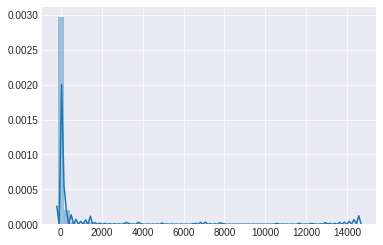

In [45]:
sns.distplot(adata.X.sum(1).A1*theta[:,9].X-ambcounts)

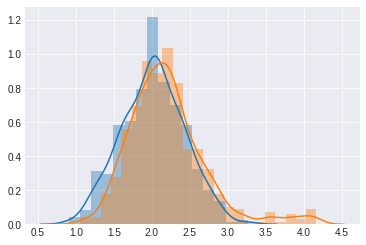

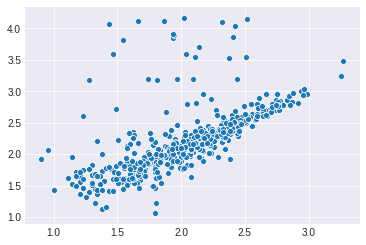

In [46]:
sns.distplot(np.log10(ambcounts))
sns.distplot(np.log10(adata.X.sum(1).A1*theta[:,9].X))
plt.show()
sns.scatterplot(np.log10(ambcounts),np.log10(adata.X.sum(1).A1*theta[:,9].X))

In [47]:
np.corrcoef(np.log10(ambcounts),np.log10(adata.X.sum(1).A1*theta[:,9].X))

array([[1.        , 0.61303641],
       [0.61303641, 1.        ]])

0.01
0.01
l __str__ = -446363.86417089944
l __str__ = -7069956.405952976
l __str__ = -706.8813377235368
l __str__ = -8148748.405952976
l __str__ = -446363.86417089944
l __str__ = -7069956.405952976
l __str__ = -706.8813377235368
l __str__ = -8148748.405952976
l __str__ = -446363.86417089944
l __str__ = -7069956.405952976
l __str__ = -706.8813377235368
l __str__ = -8148748.405952976


Average Loss = 7.3724e+06: 100%|██████████| 400/400 [01:23<00:00,  4.96it/s]
Finished [100%]: Average Loss = 7.3712e+06


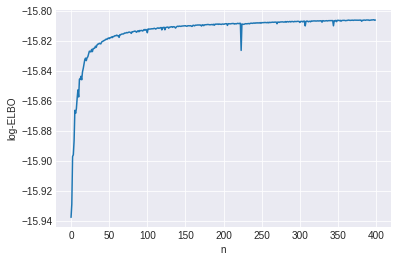

Trying to set attribute `.obs` of view, making a copy.
500it [00:11, 43.36it/s]


[[1.         0.96924316]
 [0.96924316 1.        ]]
390651.0


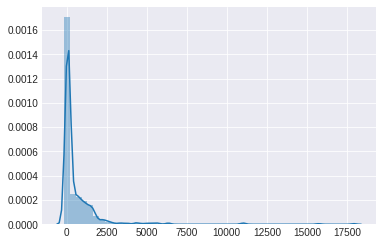

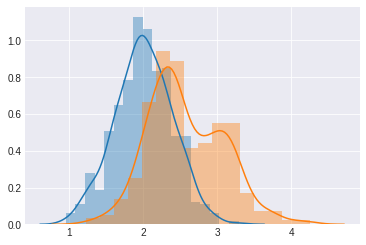

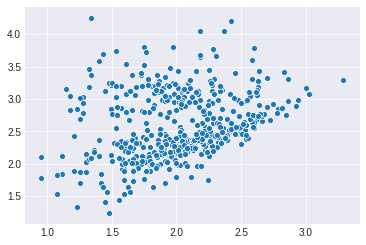

0.2744440347757768
0.01
0.1
l __str__ = -446363.86417089944
l __str__ = -7069956.405952976
l __str__ = -706.8813377235368
l __str__ = -8148748.405952976
l __str__ = -446363.86417089944
l __str__ = -7069956.405952976
l __str__ = -706.8813377235368
l __str__ = -8148748.405952976
l __str__ = -446363.86417089944
l __str__ = -7069956.405952976
l __str__ = -706.8813377235368
l __str__ = -8148748.405952976


Average Loss = 7.8149e+06:   5%|▍         | 19/400 [00:03<01:24,  4.53it/s]
Interrupted at 19 [4%]: Average Loss = 7.7143e+06


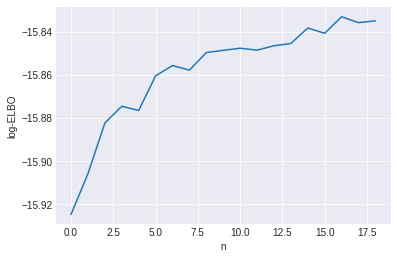

Trying to set attribute `.obs` of view, making a copy.
500it [00:11, 41.64it/s]


[[1.        0.8306936]
 [0.8306936 1.       ]]
750161.0


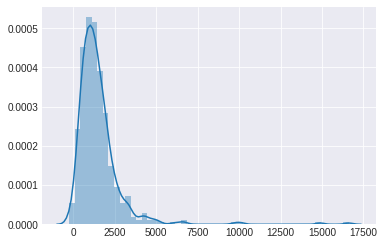

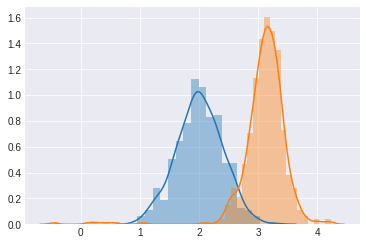

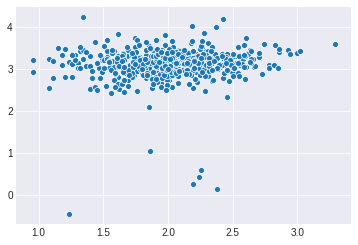

0.07844254428832298
0.01
1
l __str__ = -446363.86417089944
l __str__ = -7069956.405952976
l __str__ = -706.8813377235368
l __str__ = -8148748.405952976
l __str__ = -446363.86417089944
l __str__ = -7069956.405952976
l __str__ = -706.8813377235368
l __str__ = -8148748.405952976
l __str__ = -446363.86417089944
l __str__ = -7069956.405952976
l __str__ = -706.8813377235368
l __str__ = -8148748.405952976


Average Loss = 7.3302e+06:  83%|████████▎ | 332/400 [01:21<00:18,  3.73it/s]
Interrupted at 332 [83%]: Average Loss = 7.33e+06


KeyboardInterrupt: 

In [28]:
corrs=[]
diffs=[]
for ALPH in [.01,.1,1,10]:
    for BET in [.01,.1,1,10]:
        print(ALPH)
        print(BET)
        feature_names=list(adata.var.index)
        tf=adata.X
        n_tokens = np.sum(tf[tf.nonzero()])
        model1 = pm.Model()
        (D,V)=tf.shape
        alpha = np.ones((1, K))*ALPH
        phi = np.ones((1, V))*BET
        sparse_array=shared(np.array([tf.nonzero()[0],tf.nonzero()[1],tf.data]).T.astype('int32'))
        tt.cast(sparse_array,'int32')
        rowsums=shared(np.sum(tf,axis=1).T)
        sumall=shared(np.sum(tf))
        def lognormpdf(mean, sd):
            import math
            def internalnorm(x):
                var = float(sd)**2
                denom = tt.log(2*math.pi*var)*.5
                num = -(x-float(mean))**2/(2*var)
                return(num-denom)
            return internalnorm
        ambient=lognormpdf(ambmu,ambsd)

        def log_lda(theta, phi,value,rowsums,sumall,phiAmbient=None):
            if phiAmbient is not None:
                phi=tt.concatenate([phi,phiAmbient],axis=0)
            else:
                phi=phi
            ll = value[:,2] * pm.math.logsumexp(tt.log(theta[value[:,0].astype('int32')]+1e-9)+ tt.log(phi.T[value[:,1].astype('int32')]+1e-9),axis=1).ravel()                                                                  
            ambientll=ambient(tt.log10((rowsums+1e-9)*(theta[:,theta.shape[1]-1]+1e-9)))
            tt.printing.Print('l')(tt.sum(ambientll)*(sumall/rowsums.shape[1]))
            tt.printing.Print('l')(tt.sum(ll))
            tt.printing.Print('l')(tt.sum(ambientll)-rowsums.shape[1])
            tt.printing.Print('l')(tt.sum(ll)-sumall)
            #return tt.sum(ll) + tt.sum(ambientll)*(sumall/rowsums.shape[1])
            return (tt.sum(ll)-sumall) + (tt.sum(ambientll)-rowsums.shape[1])

        with model1: 
            theta = pm.Dirichlet("theta", a=alpha, shape=(D, K), transform=t_stick_breaking(1e-9)).astype('float32')
            phi = pm.Dirichlet("phi", a=phi, shape=(K-1, V), transform=t_stick_breaking(1e-9)).astype('float32')
            #ambient=from_epdf('ambient',ambient_counts)
            #doc = pm.DensityDist('doc', log_lda, observed=dict(theta=theta, phi=phi,ambient=ambient, value=sparse_array,phiAmbient=np.matrix([phiAmbientDict[x] for x in feature_names]),rowsums=rowsums,sumall=sumall))
            doc = pm.DensityDist('doc', log_lda, observed=dict(theta=theta,
                phi=phi,
                value=sparse_array,phiAmbient=np.matrix([phiAmbientDict[x] for x in feature_names]),rowsums=rowsums,sumall=sumall))

        eta = .3
        s = shared(eta)
        def reduce_rate(a, h, i):
            s.set_value(eta/(1+(i+1)/100)**.4)    

        with model1:    
            #inference = pm.ADVI()
            #inference = pm.FullRankADVI()
            inference=pm.variational.NFVI()
            approx = pm.fit(n=400,method= inference,obj_optimizer=pm.adam(learning_rate=s),callbacks=[pm.callbacks.CheckParametersConvergence(diff='absolute')])



        tr1 = approx.sample(draws=500)
        advi_elbo = pd.DataFrame(
            {'log-ELBO': -np.log(approx.hist),
             'n': np.arange(approx.hist.shape[0])})
        plt.clf()
        sns.lineplot(y='log-ELBO', x='n', data=advi_elbo)
        plt.show()
        plt.savefig(os.path.join(sc.settings.figdir,'ELBO.png'))
        theta=tr1['theta'].mean(0)

        theta=anndata.AnnData(theta,var=pd.DataFrame(index=['lda_'+str(i) for i in range(K) ]),obs=pd.DataFrame(index=list(adata.obs.index)))
        for i in range(theta.shape[1]):
            freshadata.obs['lda_'+str(i)]=theta[:,i].X

        # In[15]:
        phi=tr1['phi'].mean(0)
        phi=anndata.AnnData(phi,var=pd.DataFrame(index=feature_names),obs=pd.DataFrame(index=['lda_'+str(i) for i in range(K-1) ]))

        for i in range(phi.shape[0]):
            freshadata.var['lda_'+str(i)]=0
            freshadata.var.loc[list(phiAmbientDict.keys()),'lda_'+str(i)]=phi[i,:][:,list(phiAmbientDict.keys())].X
        freshadata.var['lda_'+str(K-1)]=0
        #Resort indices so the ones we're subtracting from are listed first
        freshadata.var.loc[list(phiAmbientDict.keys()),'lda_'+str(K-1)]=list(phiAmbientDict.values())
        fullinds=list(freshadata.var.index)
        [fullinds.insert(0, fullinds.pop(fullinds.index(i))) for i in feature_names[::-1]]
        freshadata=freshadata[:,fullinds]
        #Reassign phiAmbient now that matrix is reordered
        phiAmbientDict=dict(zip(list(freshadata.var.index),list(freshadata.var['lda_'+str(K-1)])))

        tmpmat3=scipy.sparse.csr_matrix(freshadata.shape)
        theta=np.matrix(freshadata.obs.loc[:,['lda' in x for x in freshadata.obs.columns]])
        phi=np.matrix(freshadata.var.loc[:,['lda' in x for x in freshadata.var.columns]])
        #txp=theta[:,0:(K-1)]*phi[:,0:(K-1)].T
        for ci,c in tqdm(enumerate(freshadata.obs.index)):
            farow=freshadata[c,:].X
            rowinds=farow.nonzero()[0]
            countz=farow[rowinds]
            rowtxp=(theta[ci,0:(K-1)]*phi[:,0:(K-1)].T).A1 #memory saving #txp[ci,:].A1
            rowtxpamb=(theta[ci,(K-1)]*phi[:,(K-1)].T).A1
            indmultiset=[[rowinds[i]]*int(countz[i]) for i in range(len(countz))]
            vals = np.array([item for sublist in indmultiset for item in sublist])
            phimultiset=[[rowtxpamb[rowind]/countz[i]]*int(countz[i]) for i,rowind in enumerate(rowinds)]
            pvals = np.array([item for sublist in phimultiset for item in sublist])
            phimultiset=[[rowtxp[rowind]+rowtxpamb[rowind]+1e-10]*int(countz[i]) for i,rowind in enumerate(rowinds)]
            pvalsdenom = np.array([item for sublist in phimultiset for item in sublist])
            pvals=pvals/(pvalsdenom)
            vals=vals[pvals>0]
            pvals=pvals[pvals>0]
            if len(vals)>0:
                #Select counts based on phiAmbient
                cellcount=np.sum(freshadata[c,:][:,feature_names].X)
                countremove=Counter(np.random.choice(vals,replace=False,size=min(len(vals),int(theta[ci,theta.shape[1]-1]*cellcount)),p=np.array(pvals)/sum(pvals))) 
                tmpmat3[ci,list(countremove.keys())]=list(countremove.values())


        theta=tr1['theta'].mean(0)
        theta=anndata.AnnData(theta,var=pd.DataFrame(index=['lda_'+str(i) for i in range(K) ]),obs=pd.DataFrame(index=list(adata.obs.index)))
        # In[15]:
        phi=tr1['phi'].mean(0)
        phi=anndata.AnnData(phi,var=pd.DataFrame(index=feature_names),obs=pd.DataFrame(index=['lda_'+str(i) for i in range(K-1) ]))
        #Reassign phiAmbient now that matrix is reordered
        phiAmbientDict=dict(zip(list(freshadata.var.index),list(freshadata.var['lda_'+str(K-1)])))
        #phiAmbient=np.array(freshadata.var['lda_'+str(K-1)])    



        theta=tr1['theta'].mean(0)
        theta=anndata.AnnData(theta,var=pd.DataFrame(index=['lda_'+str(i) for i in range(K) ]),obs=pd.DataFrame(index=list(adata.obs.index)))
        # In[15]:
        phi=tr1['phi'].mean(0)
        phi=anndata.AnnData(phi,var=pd.DataFrame(index=feature_names),obs=pd.DataFrame(index=['lda_'+str(i) for i in range(K-1) ]))
        #Reassign phiAmbient now that matrix is reordered
        phiAmbientDict=dict(zip(list(freshadata.var.index),list(freshadata.var['lda_'+str(K-1)])))
        #phiAmbient=np.array(freshadata.var['lda_'+str(K-1)])    



        print(np.corrcoef(phiAmbient, tmpmat3.sum(0)))
        print(np.absolute(tmpmat-tmpmat3).sum())
        diffs.append(np.absolute(tmpmat-tmpmat3).sum())


        sns.distplot(adata.X.sum(1).A1*theta[:,9].X-ambcounts)
        plt.show()
        sns.distplot(np.log10(ambcounts))
        sns.distplot(np.log10(adata.X.sum(1).A1*theta[:,9].X))
        plt.show()
        sns.scatterplot(np.log10(ambcounts),np.log10(adata.X.sum(1).A1*theta[:,9].X))
        plt.show()
        corrs.append(np.corrcoef(np.log10(ambcounts),np.log10(adata.X.sum(1).A1*theta[:,9].X))[0,1])
        print(np.corrcoef(np.log10(ambcounts),np.log10(adata.X.sum(1).A1*theta[:,9].X))[0,1])

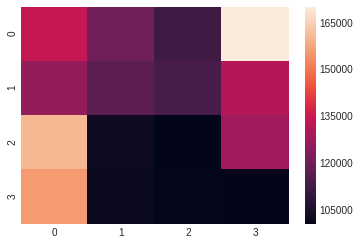

In [71]:
sns.heatmap(np.array(diffs).reshape(4,4))

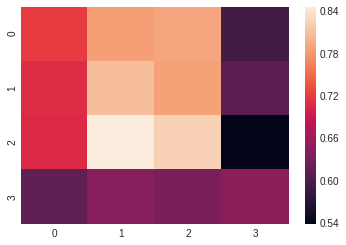

In [76]:
sns.heatmap(np.array(corrs).reshape(4,4))

In [43]:
#sc.pp.filter_genes(freshadata,min_counts=2,inplace=True)
sc.pp.filter_cells(freshadata,min_counts=500,inplace=True)
sc.pp.normalize_total(freshadata, target_sum=1e4)
sc.pp.log1p(freshadata)
sc.pp.highly_variable_genes(freshadata,n_top_genes=min(adata.shape[1],4000),inplace=True)
sc.pp.scale(freshadata, max_value=10)
sc.pp.pca(freshadata)
sc.pp.neighbors(freshadata)
sc.tl.umap(freshadata)
sc.tl.leiden(freshadata)
sc.pl.umap(freshadata, color=['leiden'],save="AfterLeiden")

sc.pl.umap(freshadata, color=['lda_0','lda_1','lda_2','lda_3','lda_4','lda_5','lda_6','lda_7','lda_8','lda_9','n_counts'],save="AfterLDA")

500it [00:10, 49.22it/s]


In [160]:
maxgenes=1000
ncells=500
headpath=os.path.expanduser("/home/mt/Downloads/")
adata=sc.read_h5ad(os.path.join(headpath,'MultiseqRaw.h5ad'))
adata._inplace_subset_obs(adata.obs['batch']=='0')
cells=np.random.choice(adata.obs.index,ncells,replace=False)
sc.pp.filter_cells(adata,min_counts=15,inplace=True)
adata._inplace_subset_obs(cells)
adata._inplace_subset_var((-adata.X).sum(0).A1.argsort()[0:min(maxgenes,adata.shape[1])])

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=min(maxgenes,4000))
sc.pp.scale(adata, max_value=10)
#sc.pp.regress_out(adata,'n_counts')

sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)
clusters=adata.obs['leiden']

In [161]:
headpath=os.path.expanduser("/home/mt/Downloads/")
adata=sc.read_h5ad(os.path.join(headpath,'MultiseqRaw.h5ad'))
adata._inplace_subset_obs(cells)
adata._inplace_subset_var((-adata.X).sum(0).A1.argsort()[0:min(maxgenes,adata.shape[1])])
adata.obs['leiden']=clusters
freshadata=adata.copy()

In [162]:
ambmu,ambsd=2.0,.4
K=10
n_iterations=120

In [163]:
clusterphis=[]
for c in set(clusters):
    clusterphis.append(adata[adata.obs['leiden']==c,:].X.sum(0).A1)
clusterphis=np.matrix(clusterphis)
clusterphis=clusterphis/(clusterphis.sum(1))

def Stick_Breaking(num_weights, alpha):
    betas = np.random.beta(1, alpha, size=num_weights)
    betas[1:] *= np.cumprod(1 - betas[:-1])
    return betas
ambprops=Stick_Breaking(len(set(clusters)),1)
ambcounts=[int(x) for x in 10**np.random.normal(ambmu,ambsd,adata.shape[0])]
print(ambprops)
sum(ambprops)


[0.07868262 0.19267869 0.16338414 0.19150957 0.22539099 0.06401751
 0.01165545 0.0310416  0.0308553 ]


0.989215886534669

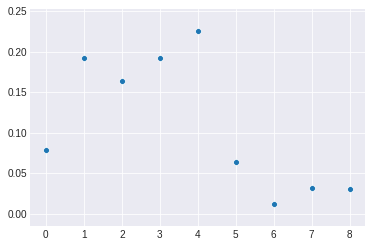

In [164]:
sns.scatterplot(list(range(len(ambprops))),ambprops)

In [165]:
phiAmbient=(ambprops*clusterphis).A1
phiAmbient=phiAmbient/phiAmbient.sum()
phiAmbientDict=dict(zip(list(adata.var.index), phiAmbient))
tmpmat=scipy.sparse.csr_matrix(adata.shape)
for ci,c in tqdm(enumerate(adata.obs.index)):
    countremove=Counter(np.random.choice(list(range(len(phiAmbient))),replace=True,size=ambcounts[ci],p=phiAmbient))
    tmpmat[ci,list(countremove.keys())]=list(countremove.values())

500it [00:00, 760.75it/s]


In [166]:
adata.X.sum()

1074145.0

In [167]:
adata.X=adata.X+tmpmat

In [168]:
adata.X.sum()

1156242.0

In [169]:
np.corrcoef(tmpmat.sum(0).A1,phiAmbient)

array([[1.        , 0.99978386],
       [0.99978386, 1.        ]])

In [170]:
feature_names=list(adata.var.index)
tf=adata.X
n_tokens = np.sum(tf[tf.nonzero()])
print('Number of tokens in training set = {}'.format(n_tokens))
print('Sparsity = {}'.format(
    len(tf.nonzero()[0]) / float(tf.shape[0] * tf.shape[1])))

model1 = pm.Model()
(D,V)=tf.shape
print(D,V)
alpha = np.ones((1, K))
phi = np.ones((1, V))
sparse_array=shared(np.array([tf.nonzero()[0],tf.nonzero()[1],tf.data]).T.astype('int32'))
tt.cast(sparse_array,'int32')
rowsums=shared(np.sum(tf,axis=1).T)
sumall=shared(np.sum(tf))
def lognormpdf(mean, sd):
    import math
    def internalnorm(x):
        var = float(sd)**2
        denom = tt.log(2*math.pi*var)*.5
        num = -(x-float(mean))**2/(2*var)
        return(num-denom)
    return internalnorm
ambient=lognormpdf(ambmu,ambsd)

def log_lda(theta, phi,value,rowsums,sumall,phiAmbient=None):
    if phiAmbient is not None:
        phi=tt.concatenate([phi,phiAmbient],axis=0)
    else:
        phi=phi
    ll = value[:,2] * pm.math.logsumexp(tt.log(theta[value[:,0].astype('int32')]+1e-9)+ tt.log(phi.T[value[:,1].astype('int32')]+1e-9),axis=1).ravel()                                                                  
    ambientll=ambient(tt.log10((rowsums+1e-9)*(theta[:,theta.shape[1]-1]+1e-9)))
    tt.printing.Print('l')(tt.sum(ambientll)*(sumall/rowsums.shape[1]))
    tt.printing.Print('l')(tt.sum(ll))
    tt.printing.Print('l')(tt.sum(ambientll)-rowsums.shape[1])
    tt.printing.Print('l')(tt.sum(ll)-sumall)
    #return tt.sum(ll) + tt.sum(ambientll)*(sumall/rowsums.shape[1])
    return (tt.sum(ll)-sumall) + (tt.sum(ambientll)-rowsums.shape[1])

with model1: 
    theta = pm.Dirichlet("theta", a=alpha, shape=(D, K), transform=t_stick_breaking(1e-9)).astype('float32')
    phi = pm.Dirichlet("phi", a=phi, shape=(K-1, V), transform=t_stick_breaking(1e-9)).astype('float32')
    #ambient=from_epdf('ambient',ambient_counts)
    #doc = pm.DensityDist('doc', log_lda, observed=dict(theta=theta, phi=phi,ambient=ambient, value=sparse_array,phiAmbient=np.matrix([phiAmbientDict[x] for x in feature_names]),rowsums=rowsums,sumall=sumall))
    doc = pm.DensityDist('doc', log_lda, observed=dict(theta=theta,
        phi=phi,
        value=sparse_array,phiAmbient=np.matrix([phiAmbientDict[x] for x in feature_names]),rowsums=rowsums,sumall=sumall))

eta = .3
s = shared(eta)
def reduce_rate(a, h, i):
    s.set_value(eta/((i/10)+1)**.4)    

Number of tokens in training set = 1156242.0
Sparsity = 0.523124
500 1000
l __str__ = -534138.2328659354
l __str__ = -7471625.511612547
l __str__ = -730.9802934272996
l __str__ = -8627867.511612546
l __str__ = -534138.2328659354
l __str__ = -7471625.511612547
l __str__ = -730.9802934272996
l __str__ = -8627867.511612546
l __str__ = -534138.2328659354
l __str__ = -7471625.511612547
l __str__ = -730.9802934272996
l __str__ = -8627867.511612546


In [171]:
with model1:    
    #inference = pm.ADVI()
    #inference = pm.FullRankADVI()
    inference=pm.variational.NFVI()
    approx = pm.fit(n=200,method= inference,obj_optimizer=pm.adam(learning_rate=s),callbacks=[pm.callbacks.CheckParametersConvergence(diff='absolute')])


Average Loss = 7.7231e+06: 100%|██████████| 200/200 [00:35<00:00,  5.91it/s]
Finished [100%]: Average Loss = 7.7187e+06


[[1.        0.2542435]
 [0.2542435 1.       ]]


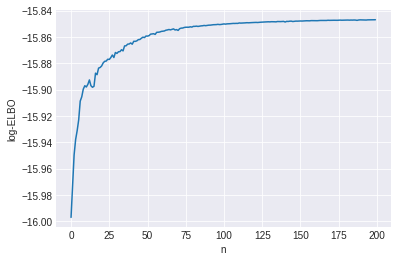

In [172]:

tr1 = approx.sample(draws=1000)
advi_elbo = pd.DataFrame(
    {'log-ELBO': -np.log(approx.hist),
     'n': np.arange(approx.hist.shape[0])})
plt.clf()
sns.lineplot(y='log-ELBO', x='n', data=advi_elbo)
plt.savefig(os.path.join(sc.settings.figdir,'ELBO.png'))
theta=tr1['theta'].mean(0)
print(np.corrcoef(adata.X.sum(1).A1*theta[:,9],ambcounts))

theta=anndata.AnnData(theta,var=pd.DataFrame(index=['lda_'+str(i) for i in range(K) ]),obs=pd.DataFrame(index=list(adata.obs.index)))
for i in range(theta.shape[1]):
    freshadata.obs['lda_'+str(i)]=theta[:,i].X

# In[15]:
phi=tr1['phi'].mean(0)
phi=anndata.AnnData(phi,var=pd.DataFrame(index=feature_names),obs=pd.DataFrame(index=['lda_'+str(i) for i in range(K-1) ]))

for i in range(phi.shape[0]):
    freshadata.var['lda_'+str(i)]=0
    freshadata.var.loc[list(phiAmbientDict.keys()),'lda_'+str(i)]=phi[i,:][:,list(phiAmbientDict.keys())].X
freshadata.var['lda_'+str(K-1)]=0
#Resort indices so the ones we're subtracting from are listed first
freshadata.var.loc[list(phiAmbientDict.keys()),'lda_'+str(K-1)]=list(phiAmbientDict.values())
fullinds=list(freshadata.var.index)
[fullinds.insert(0, fullinds.pop(fullinds.index(i))) for i in feature_names[::-1]]
freshadata=freshadata[:,fullinds]
#Reassign phiAmbient now that matrix is reordered
phiAmbientDict=dict(zip(list(freshadata.var.index),list(freshadata.var['lda_'+str(K-1)])))

In [173]:
tmpmat3=scipy.sparse.csr_matrix(freshadata.shape)
theta=np.matrix(freshadata.obs.loc[:,['lda' in x for x in freshadata.obs.columns]])
phi=np.matrix(freshadata.var.loc[:,['lda' in x for x in freshadata.var.columns]])
#txp=theta[:,0:(K-1)]*phi[:,0:(K-1)].T
for ci,c in tqdm(enumerate(freshadata.obs.index)):
    farow=freshadata[c,:].X
    rowinds=farow.nonzero()[0]
    countz=farow[rowinds]
    rowtxp=(theta[ci,0:(K-1)]*phi[:,0:(K-1)].T).A1 #memory saving #txp[ci,:].A1
    rowtxpamb=(theta[ci,(K-1)]*phi[:,(K-1)].T).A1
    indmultiset=[[rowinds[i]]*int(countz[i]) for i in range(len(countz))]
    vals = np.array([item for sublist in indmultiset for item in sublist])
    phimultiset=[[rowtxpamb[rowind]/countz[i]]*int(countz[i]) for i,rowind in enumerate(rowinds)]
    pvals = np.array([item for sublist in phimultiset for item in sublist])
    phimultiset=[[rowtxp[rowind]+rowtxpamb[rowind]+1e-10]*int(countz[i]) for i,rowind in enumerate(rowinds)]
    pvalsdenom = np.array([item for sublist in phimultiset for item in sublist])
    pvals=pvals/(pvalsdenom)
    vals=vals[pvals>0]
    pvals=pvals[pvals>0]
    if len(vals)>0:
        #Select counts based on phiAmbient
        cellcount=np.sum(freshadata[c,:][:,feature_names].X)
        countremove=Counter(np.random.choice(vals,replace=False,size=min(len(vals),int(theta[ci,theta.shape[1]-1]*cellcount)),p=np.array(pvals)/sum(pvals))) 
        tmpmat3[ci,list(countremove.keys())]=list(countremove.values())


500it [00:09, 58.31it/s]


In [174]:
theta=tr1['theta'].mean(0)
theta=anndata.AnnData(theta,var=pd.DataFrame(index=['lda_'+str(i) for i in range(K) ]),obs=pd.DataFrame(index=list(adata.obs.index)))
# In[15]:
phi=tr1['phi'].mean(0)
phi=anndata.AnnData(phi,var=pd.DataFrame(index=feature_names),obs=pd.DataFrame(index=['lda_'+str(i) for i in range(K-1) ]))
#Reassign phiAmbient now that matrix is reordered
phiAmbientDict=dict(zip(list(freshadata.var.index),list(freshadata.var['lda_'+str(K-1)])))
#phiAmbient=np.array(freshadata.var['lda_'+str(K-1)])    

tmpmat2=scipy.sparse.csr_matrix(freshadata.shape)
for ci,c in tqdm(enumerate(freshadata.obs.index)):
    farow=freshadata[c,:].X
    rowinds=farow.nonzero()[0]
    countz=farow[rowinds]
    rownames=freshadata.var.index[rowinds]
    indmultiset=[[rowinds[i]]*int(countz[i]) for i in range(len(countz))]
    vals = [item for sublist in indmultiset for item in sublist]
    #phimultiset=[[phiAmbientDict[rowname]]*int(countz[i]) for i,rowname in enumerate(rownames)]
    phimultiset=[[phiAmbientDict[rowname]/countz[i]]*int(countz[i]) for i,rowname in enumerate(rownames)]
    pvals = [item for sublist in phimultiset for item in sublist]
    if len(vals)>0:
        #Select counts based on phiAmbient
        cellcount=np.sum(freshadata[c,:][:,feature_names].X)
        countremove=Counter(np.random.choice(vals,replace=False,size=min(len(vals),int(theta[c,theta.shape[1]-1].X*cellcount)),p=np.array(pvals)/sum(pvals))) 
        tmpmat2[ci,list(countremove.keys())]=list(countremove.values())


500it [00:09, 54.61it/s]


In [175]:
print(np.corrcoef(phiAmbient, tmpmat3.sum(0)))
print(np.corrcoef(phiAmbient, tmpmat2.sum(0)))
(tmpmat-tmpmat3).sum()

[[1.         0.87702186]
 [0.87702186 1.        ]]
[[1.         0.93499451]
 [0.93499451 1.        ]]


-26810.0

In [176]:
print(np.absolute(tmpmat-tmpmat2).sum())
print(np.absolute(tmpmat-tmpmat3).sum())
print(np.absolute(tmpmat-tmpmat3).sum(0))
print(np.absolute(tmpmat.sum()))


141116.0
162960.0
[[3.5360e+03 3.4480e+03 4.1293e+04 1.6670e+03 1.2460e+03 1.1850e+03
  1.2070e+03 8.5300e+02 6.9000e+02 6.2900e+02 5.4700e+02 5.3700e+02
  5.4400e+02 5.0700e+02 1.0429e+04 4.6800e+02 4.0600e+02 4.7800e+02
  3.7400e+02 4.0400e+02 3.8400e+02 7.5560e+03 3.6600e+02 3.4300e+02
  3.2300e+02 3.6500e+02 3.0300e+02 3.2900e+02 2.8800e+02 3.1100e+02
  3.3100e+02 2.9600e+02 3.2400e+02 3.0500e+02 3.3200e+02 3.0700e+02
  2.8400e+02 2.8700e+02 3.1000e+02 3.0700e+02 2.7700e+02 2.7100e+02
  4.8300e+02 2.7600e+02 2.9300e+02 2.6100e+02 3.1500e+02 2.7900e+02
  2.6500e+02 3.3300e+02 2.4000e+02 2.6100e+02 2.4600e+02 2.5400e+02
  2.4500e+02 2.6100e+02 2.2200e+02 2.3800e+02 2.2600e+02 2.6300e+02
  2.6000e+02 2.2300e+02 2.2800e+02 2.7100e+02 2.4000e+02 2.5300e+02
  2.4800e+02 2.2300e+02 1.9700e+02 2.2700e+02 2.1800e+02 2.2500e+02
  2.2400e+02 2.2800e+02 2.2600e+02 2.4900e+02 2.1000e+02 2.2800e+02
  2.4500e+02 2.1500e+02 2.0500e+02 1.9600e+02 2.1900e+02 1.9800e+02
  2.2400e+02 2.0000e+02 2.1200

In [177]:
np.corrcoef(adata.X.sum(1).A1*theta[:,9].X,ambcounts)

array([[1.       , 0.2542435],
       [0.2542435, 1.       ]])

In [178]:
adata.X.sum(1).A1*theta[:,9].X

ArrayView([  205.59538671,   153.36550868,    18.47823457,   215.24476722,
             262.26940481,   103.2580009 ,    22.70603621,   115.91922126,
             210.05072482,    40.99374538,    72.04458154,   301.3791461 ,
             115.64193216,    75.45029281,    31.07024454,   148.80693269,
            6933.95149469,   277.74004269,   125.79348583,   122.48460738,
              68.92085819,   129.43483086,    90.19578807,  2421.51405722,
             770.42443228,    23.56463782,    95.81886788,    32.71030772,
              42.52644083,   187.15171996,    30.00186741,   517.08613068,
              64.4347399 ,   266.81843343,    73.79851341,    56.35447307,
              46.25090073,   107.62001261,   541.80062699,    72.50213481,
              35.91687282,   209.95966652,    35.90997723,   110.05318084,
              51.43158376,    64.45826203,   350.74969433,    70.23293105,
              34.92126744,    80.70931404,    93.86303549,   131.59233204,
              42.33592574

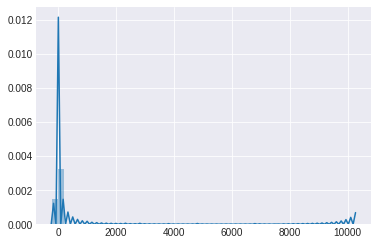

In [179]:
sns.distplot(adata.X.sum(1).A1*theta[:,9].X-ambcounts)

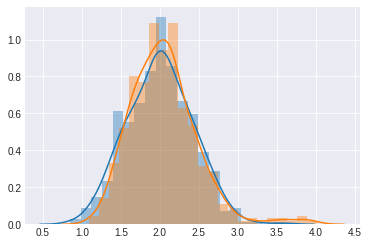

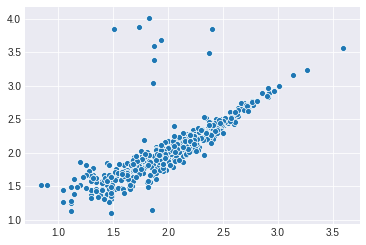

In [180]:
sns.distplot(np.log10(ambcounts))
sns.distplot(np.log10(adata.X.sum(1).A1*theta[:,9].X))
plt.show()
sns.scatterplot(np.log10(ambcounts),np.log10(adata.X.sum(1).A1*theta[:,9].X))

In [181]:
adata.X.sum(1).A1*theta[:,9].X

ArrayView([  205.59538671,   153.36550868,    18.47823457,   215.24476722,
             262.26940481,   103.2580009 ,    22.70603621,   115.91922126,
             210.05072482,    40.99374538,    72.04458154,   301.3791461 ,
             115.64193216,    75.45029281,    31.07024454,   148.80693269,
            6933.95149469,   277.74004269,   125.79348583,   122.48460738,
              68.92085819,   129.43483086,    90.19578807,  2421.51405722,
             770.42443228,    23.56463782,    95.81886788,    32.71030772,
              42.52644083,   187.15171996,    30.00186741,   517.08613068,
              64.4347399 ,   266.81843343,    73.79851341,    56.35447307,
              46.25090073,   107.62001261,   541.80062699,    72.50213481,
              35.91687282,   209.95966652,    35.90997723,   110.05318084,
              51.43158376,    64.45826203,   350.74969433,    70.23293105,
              34.92126744,    80.70931404,    93.86303549,   131.59233204,
              42.33592574

Trying to set attribute `.obs` of view, making a copy.


saving figure to file ./figures/umapAfterLeiden.pdf


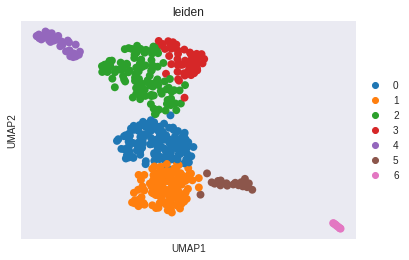

saving figure to file ./figures/umapAfterLDA.pdf


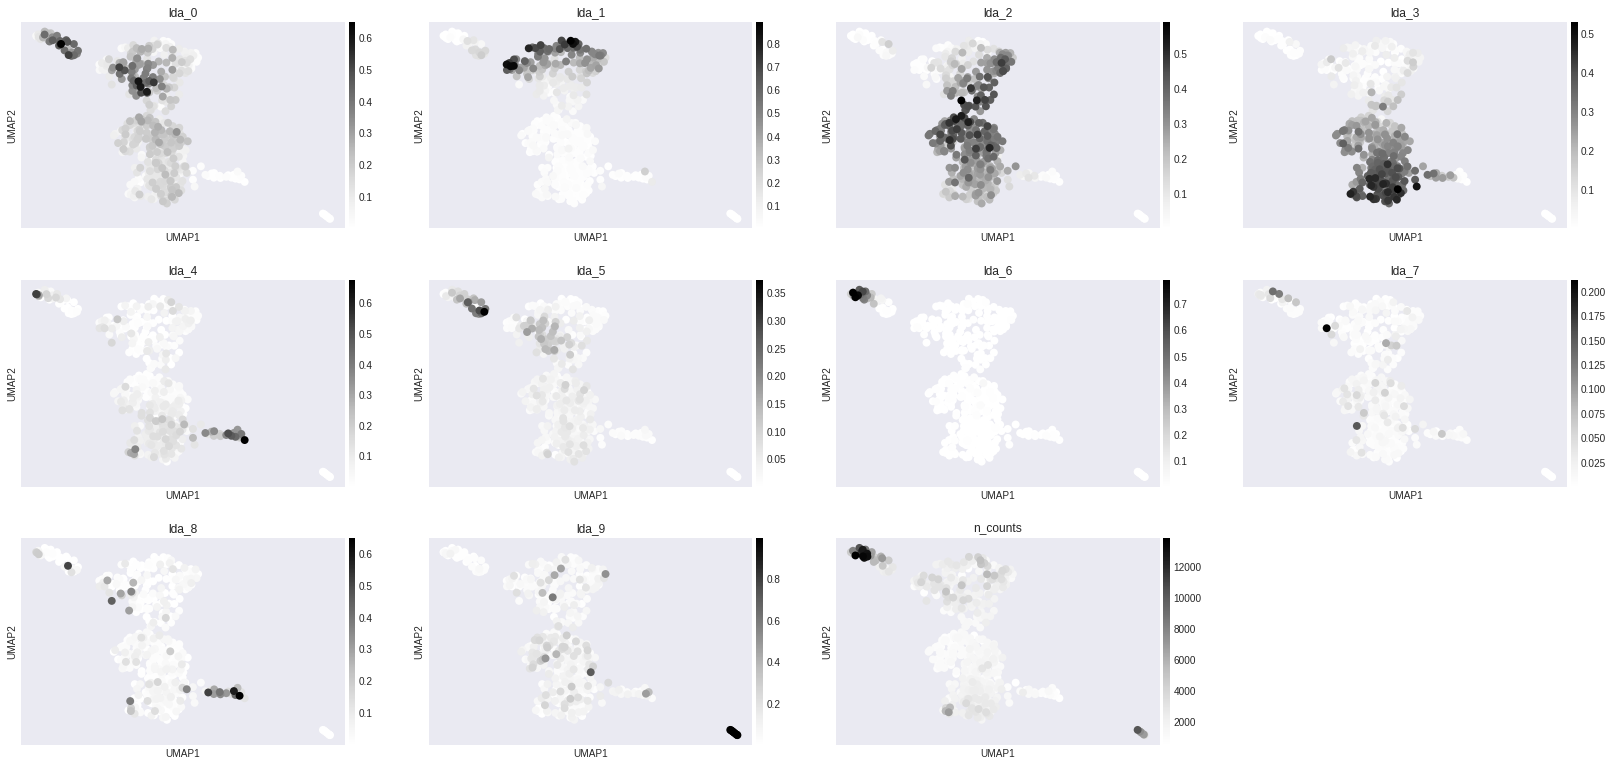

In [182]:

#sc.pp.filter_genes(freshadata,min_counts=2,inplace=True)
sc.pp.filter_cells(freshadata,min_counts=500,inplace=True)
sc.pp.normalize_total(freshadata, target_sum=1e4)
sc.pp.log1p(freshadata)
sc.pp.highly_variable_genes(freshadata,n_top_genes=min(adata.shape[1],4000),inplace=True)
sc.pp.scale(freshadata, max_value=10)
sc.pp.pca(freshadata)
sc.pp.neighbors(freshadata)
sc.tl.umap(freshadata)
sc.tl.leiden(freshadata)
sc.pl.umap(freshadata, color=['leiden'],save="AfterLeiden")

sc.pl.umap(freshadata, color=['lda_0','lda_1','lda_2','lda_3','lda_4','lda_5','lda_6','lda_7','lda_8','lda_9','n_counts'],save="AfterLDA")